In [47]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 

In [4]:
# read all the words from text 
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# number of words 
len(words)

32033

In [11]:
# build the vocabulary of chars and mapping from/to integers 
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [49]:
# build the data set 

block_size = 3 # the context length (how many chars to consider to make prediction)

def build_dataset(words):
    X, Y = [], []
    for w in words:              # let's test the code for first 3 words 
        context = [0]*block_size     
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append (this moves the window by one char forward)
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

# create training and test data sets 
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

In [50]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((27,10),generator=g)          # this is the embedding vector (to project each text to 10 dim space)
W1 = torch.randn((30,200),generator=g)        # first layer weights (30 = block_size * 10)
b1 = torch.randn(200,generator=g)             # layer 1 bias 
W2 = torch.randn((200,27),generator=g)        # layer 2 weight 
b2 = torch.randn(27,generator=g)              # layer 2 bias 
parameters = [C,W1,b1,W2,b2]                  # list of all the parameters (we need to minimize the loss wrt this later)


In [51]:
# total number of parameters 
sum(p.nelement() for p in parameters)

11897

In [52]:
# turn on the gradient tracking of parameters 
for p in parameters:
    p.requires_grad = True

In [39]:
# set the learning rate [0,1] in exponential growth 
lre = torch.linspace(-3,0,100)
lrs = 10**lre

In [53]:
Xtr.shape

torch.Size([182437, 3])

In [64]:
stepi = []
lossi = []
lri   = []

# train the model 
for i in range(100000):
    ix = torch.randint(0,Xtr.shape[0],(32,)) # select mini batch of size 32 
    
    # forward pass
    emb = C[Xtr[ix]] # (32,3,10)
    h = torch.tanh(emb.view(-1,30)) @ W1 + b1 #(32,200)
    logits = h @ W2 + b2 # (32,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    
    # backward 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights 
    lr = 0.1 if i <10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    
    # track the status 
    stepi.append(i)
    lossi.append(loss.log10().item())

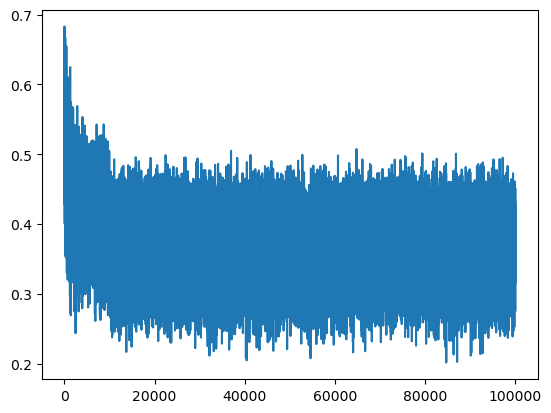

In [65]:
plt.plot(stepi,lossi)

In [66]:
# let's see the validation loss 
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.8108, grad_fn=<NllLossBackward0>)

In [67]:
# generate names from the model 

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True: 
        emb = C[torch.tensor([context])] # (1,block_size,embedding dim)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break 
    print(''.join(itos[i] for i in out))


mora.
amyah.
see.
modhryal.
tethrdiondrlee.
azeh.
doelicesdysonaldie.
susownartemy.
korlyaghi.
sadbergyvianeet.
juje.
telina.
teroftuxdbrvdo.
xysone.
ehs.
karjhysthyanthil.
sadyansyf.
zakhuvauten.
trb.
waveaietharrdinkengoe.
